## Introducing Parcel Data

The following notebook utilizes parcel data in California to more accurately retain the proper building footprints (avoiding missing data that occurred when Zillow data points did not perfectly overlap multi-unit housing complexes).

Steps:
1. Load parcel and Zillow data
2. Left join Zillow data to parcel data (keeping only parcels with Zillow points)
3. Load building footprint data
4. Left join parcel data to building footprint data (keeping only buildings within Zillow parcels)
5. Make sure that Zillow data is properly applied to each multi-unit home?
6. Create linear regression to predict # of units for buildings that are missing data

**Note:** Data import takes approximately 20 minutes.

In [7]:
import pandas as pd
from shapely.geometry import box
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import zipfile
import fiona

from sklearn.linear_model import LinearRegression

In [8]:
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

### Load data

**Zillow**

In [14]:
# read in the zillow geo data (takes about 10 minutes)
fp = os.path.join('data', 'final_zillow.gpkg')
zillow = gpd.read_file(fp)

In [15]:
# convert to standard CRS (takes about 1 min)
zillow = zillow.to_crs(epsg = 4326)

**Building footprints (from parquet file)**

In [20]:
# read in original building data
# specify tile download url; this url is for area containing Santa Barbara, CA
fp = os.path.join('data', 'building_parquets', 'w120_n35_w115_n30.parquet')

# read the parquet file into a DataFrame
building = gpd.read_parquet(fp)

In [22]:
building = building.to_crs(epsg=4326)

In [ ]:
# extract limit information from `bbox` column using shapely (also takes some time)
building_pqt["geometry"] = building_pqt["bbox"].apply(
    lambda b: box(b["xmin"], b["ymin"], b["xmax"], b["ymax"])
)

In [ ]:
# convert dataframe to a geopandas object
building_raw = gpd.GeoDataFrame(building_pqt, geometry="geometry", crs="EPSG:4326")

# confirm transformation worked and we have a geodataframe
building_raw.head()

**Parcel data**

In [9]:
# check what layers are in the geodatabase
fiona.listlayers("data/Parcels_CA_2014.gdb")

['CA_PARCELS_STATEWIDE_INFO', 'CA_PARCELS_STATEWIDE']

In [10]:
# Then read the extracted .gbd file (takes about 5 minutes)
parcels = gpd.read_file("data/Parcels_CA_2014.gdb", layer = 'CA_PARCELS_STATEWIDE')

parcels.head()

,PARNO,County,ADDRESS,CITY,ZIP,Shape_Length,Shape_Area,geometry
0,48-6298-3-2,Alameda,None,None,None,103.683187,606.327284,MULTIPOLYGON Z (((-186849.018 -26883.062 0.000...
1,48-6313-23,Alameda,None,None,None,148.045063,1083.135315,MULTIPOLYGON Z (((-186958.510 -27039.207 0.000...
2,48-6313-87,Alameda,None,None,None,97.520632,557.505860,MULTIPOLYGON Z (((-187075.438 -27105.852 0.000...
3,48-6330-8-2,Alameda,None,None,None,171.271160,1602.682949,MULTIPOLYGON Z (((-186735.283 -27337.704 0.000...
4,48-6432-32,Alameda,None,None,None,140.208009,1078.107621,MULTIPOLYGON Z (((-187227.051 -26275.709 0.000...


In [11]:
# convert parcels to standard CRS
parcels = parcels.to_crs(epsg=4326)

In [16]:
parcels.dtypes

PARNO             object
County            object
ADDRESS           object
CITY              object
ZIP               object
Shape_Length     float64
Shape_Area       float64
geometry        geometry
dtype: object

### Select only residential parcels
By joining Zillow data to parcels. Parcel data is stored as a single geometry per county.

In [17]:
# view what parcel geometry looks like for one county
parcels['County'].unique()

array(['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras',
       'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn',
       'Humboldt', 'Imperial', 'Kern', 'Kings', 'Lake', 'Lassen',
       'Los Angeles', 'Madera', 'Marin', 'Mendocino', 'Merced', 'Mono',
       'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Riverside',
       'Sacramento', 'San Benito', 'San Bernardino', 'San Diego',
       'San Francisco', 'San Joaquin', 'San Mateo', 'Santa Barbara',
       'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Solano',
       'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare',
       'Tuolumne', 'Ventura', 'Yolo', 'Yuba'], dtype=object)

<Axes: >

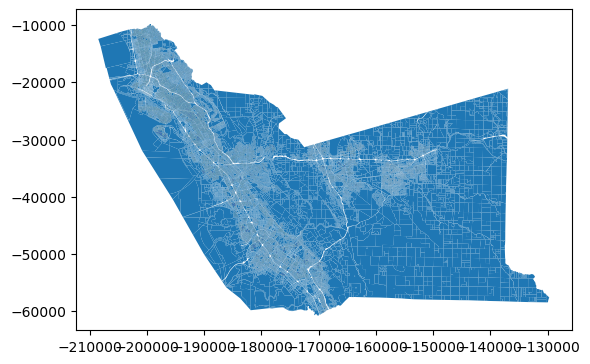

In [18]:
parcels[parcels['County'] == 'Alameda'].plot()

<Axes: >

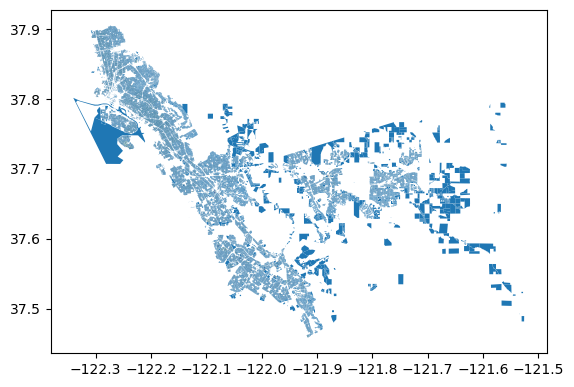

In [19]:
parcels_res[parcels_res['County'] == 'Alameda'].plot()

### Exploding parcels to get them as individual units, but unclear if necessary

In [19]:
# explode! (takes 1 min) --> might not be necessary?
# parcels_exploded = parcels.explode(index_parts=False).reset_index(drop=True)

In [20]:
# make sure exploding works
# print(f"Original rows: {len(parcels)}")
# print(f"Exploded rows: {len(parcels_exploded)}")

Original rows: 11523701
Exploded rows: 11584035


In [16]:
valid_parcels = parcels.sjoin(zillow, predicate="contains").index.unique()
parcels_res = parcels.loc[valid_parcels]

In [37]:
# residential parcels (should keep only parcels that contain Zillow points)
# (takes about 7 minutes)
parcels_res = gpd.sjoin(
    zillow,
    parcels,
    how = "inner",
    predicate = "intersects"
)

In [38]:
parcels_res.head(2)

,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,...,code,geometry,index_right,PARNO,County,ADDRESS,CITY,ZIP,Shape_Length,Shape_Area
0,Multi,2003.0,1.0,None,None,I,224.0,491943.0,living,1003.0,...,RR106,POINT (-122.26800 37.79429),87223,1-1111-22,Alameda,None,None,None,304.952483,5582.905556
1,Multi,2003.0,1.0,None,None,None,224.0,240117.0,living,936.0,...,RR106,POINT (-122.26800 37.79429),87223,1-1111-22,Alameda,None,None,None,304.952483,5582.905556


In [17]:
# confirm that joining with Zillow decreased the number of parcels
print(f"Original parcel rows: {len(parcels)}")
print(f"Residential parcel rows: {len(parcels_res)}")
print(f"There are less residential parcels than total parcels: {len(parcels_res) < len(parcels)}")

Original parcel rows: 11523701
Residential parcel rows: 8818905
There are less residential parcels than total parcels: True


### Select buildings only in residential parcels

In [30]:
# keep all residential parcels and attach buildings within them
buildings_res = gpd.sjoin(
    building,
    parcels_res,
    how = "inner",
    predicate = "within"
)

In [ ]:
# a method of removing duplicates that doesn't work
buildings_res = buildings_res.drop_duplicates(subset=building.index.name or 'index')

In [32]:
# a method that might work
buildings_res = buildings_res.loc[buildings_res.index.unique()]

In [33]:
# confirm that joining with parcel data decreased the number of buildings
print(f"Original parcel rows: {len(building)}")
print(f"Residential parcel rows: {len(buildings_res)}")
print(f"There are less residential parcels than total parcels: {len(buildings_res) < len(building)}")

Original parcel rows: 9503685
Residential parcel rows: 14136216
There are less residential parcels than total parcels: False


In [ ]:
# drop parcels column (don't need it anymore)
building_res = building_res.drop(["insert parcel column name"], axis = 1)

### Attach Zillow data to residential buildings

In [ ]:
# keep all residential buildings, and add zillow points only where they match up
building = gpd.sjoin(
    building_res,
    zillow,
    how = "left",
    predicate = "intersects")

### Find volume information from building footprints

In [ ]:
# reproject data frame to crs with meters as units
building_m = building.to_crs("EPSG:6933")

In [ ]:
# find and create column from polygon area
building_m['area_m2'] = building_m.geometry.area

# rename height column to be clear about units
building_m.rename(columns={"height":"height_m"}, inplace = True)

building_m.head(2)

In [ ]:
# create volume column
building_m['volume_m3'] = building_m['area_m2'] * building_m['height_m']

building_m.head(2)

In [ ]:
# explore number of rows that don't have unit data -- it's a lot
building_m['unit'].isna().sum()

In [ ]:
# keep only observations with unit data
building_w_units = building_m[~building_m['unit'].isna()]

# confirm operation worked
building_w_units['unit'].isna().sum()

### Regression analysis

In [ ]:
# plot units vs volume^3
building_w_units.plot(kind='scatter',
              x='volume_m3', 
              y='unit')

In [ ]:
# x-values
x = np.array(building_w_units['volume_m3']).reshape((-1,1)) # Reshape to (n_samples, 1) ; -1 tells numpy that it can figure out how many rows we need
print(f"Input data shape: {x.shape}")

# y-values
y = np.array(building_w_units['unit'])
print(f"Output data shape: {y.shape}")

In [ ]:
# Fit model
model = LinearRegression().fit(x, y)

In [ ]:
R_sq = model.score(x,y)
print(f"Coefficient of determination (R^2): {R_sq}")

# Retrieve intercept and slope
intercept = model.intercept_
print(f"x-axis intercept: {intercept}")

slope = model.coef_[0]
print(f"Slope: {slope}")